# `streamline_non_weather_augmentation.ipynb`

### Author: Anthony Hein

#### Last updated: 11/3/2021

# Overview:

Augment the racing dataset so that each row includes additional columns which summarize the race. These columns are mostly derived from data in the `horses_selected.csv` that was determined to be more suitable as part of the `races_selected.csv`, such as `runners`, `margin`, and information about winners, compared to the posted odds. None of these columns contain weather data.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_selected.csv`

In [3]:
horses_selected = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected.csv", low_memory=False) 
horses_selected.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,TR,OR,father,mother,gfather,runners,margin,weight,res_win,res_place
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,NaN,...,NaN,NaN,King's Ride,Browne's Return,Deep Run,6,1.219263,73,1.0,1.0
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,NaN,Long Pond,Courtlough Lady,Giolla Mear,6,1.219263,73,0.0,1.0
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,NaN,Nordico,Over The Seas,North Summit,6,1.219263,71,0.0,0.0
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,Roselier,Miss Reindeer,Reindeer,6,1.219263,73,0.0,0.0
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,Noalto,Elena's Beauty,Tarqogan,6,1.219263,66,0.0,0.0


In [4]:
horses_selected.shape

(205138, 27)

---

## Load `races_selected.csv`

In [5]:
races_selected = pd.read_csv(f"{BASE_DIR}/data/streamline/races_selected.csv", low_memory=False) 
races_selected.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,runners
0,302858,Thurles (IRE),01:15,97/01/09,Liffey Maiden Hurdle (Div 1),NaN,NaN,5yo+,2m3f,Good,NaN,[],277.2,NaN,3821.0,IE,1,0,6
1,291347,Punchestown (IRE),03:40,97/02/16,Ericsson G.S.M. Grand National Trial Handicap ...,NaN,NaN,5yo+,3m2f,Soft,NaN,[],447.2,NaN,5229.0,IE,5,0,9
2,75447,Listowel (IRE),03:00,97/03/01,Ballybunion E.B.F. Beginners S'chase,NaN,NaN,4yo+,2m2f,Soft,NaN,[],318.4,NaN,3620.0,IE,5,0,8
3,358038,Punchestown (IRE),02:40,97/04/24,Quinns Of Baltinglass Chase (La Touche) (Cross...,NaN,NaN,5yo+,4m1f,Good,NaN,[],533.9,NaN,6637.0,IE,1,0,10
4,78982,Dundalk (IRE),05:15,97/05/02,Carlingford Handicap Chase,NaN,0-109,4yo+,3m,Firm,NaN,[],370.3,NaN,4827.0,IE,8,0,4


In [6]:
races_selected.shape

(20574, 19)

In [7]:
races_selected_augment_non_weather = races_selected.copy()
races_selected_augment_non_weather.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,runners
0,302858,Thurles (IRE),01:15,97/01/09,Liffey Maiden Hurdle (Div 1),NaN,NaN,5yo+,2m3f,Good,NaN,[],277.2,NaN,3821.0,IE,1,0,6
1,291347,Punchestown (IRE),03:40,97/02/16,Ericsson G.S.M. Grand National Trial Handicap ...,NaN,NaN,5yo+,3m2f,Soft,NaN,[],447.2,NaN,5229.0,IE,5,0,9
2,75447,Listowel (IRE),03:00,97/03/01,Ballybunion E.B.F. Beginners S'chase,NaN,NaN,4yo+,2m2f,Soft,NaN,[],318.4,NaN,3620.0,IE,5,0,8
3,358038,Punchestown (IRE),02:40,97/04/24,Quinns Of Baltinglass Chase (La Touche) (Cross...,NaN,NaN,5yo+,4m1f,Good,NaN,[],533.9,NaN,6637.0,IE,1,0,10
4,78982,Dundalk (IRE),05:15,97/05/02,Carlingford Handicap Chase,NaN,0-109,4yo+,3m,Firm,NaN,[],370.3,NaN,4827.0,IE,8,0,4


---

## Augment `races_selected.csv` w/ `margin` Information

In [8]:
rid_to_margin = {}
for rid in tqdm(races_selected['rid']):
    rid_to_margin[rid] = sum(horses_selected[horses_selected['rid'] == rid]['decimalPrice'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20574/20574 [00:10<00:00, 2039.62it/s]


In [9]:
rename_cols = {
    'index': 'rid',
    0: 'margin',
}

df_margins = pd.DataFrame.from_dict(rid_to_margin, orient='index').reset_index().rename(columns=rename_cols)
df_margins.head()

,rid,margin
0,302858,1.219263
1,291347,1.218049
2,75447,1.277320
3,358038,1.286595
4,78982,1.090018


In [10]:
races_selected_augment_non_weather = races_selected_augment_non_weather.merge(df_margins, how='inner', on='rid')
races_selected_augment_non_weather.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,runners,margin
0,302858,Thurles (IRE),01:15,97/01/09,Liffey Maiden Hurdle (Div 1),NaN,NaN,5yo+,2m3f,Good,NaN,[],277.2,NaN,3821.0,IE,1,0,6,1.219263
1,291347,Punchestown (IRE),03:40,97/02/16,Ericsson G.S.M. Grand National Trial Handicap ...,NaN,NaN,5yo+,3m2f,Soft,NaN,[],447.2,NaN,5229.0,IE,5,0,9,1.218049
2,75447,Listowel (IRE),03:00,97/03/01,Ballybunion E.B.F. Beginners S'chase,NaN,NaN,4yo+,2m2f,Soft,NaN,[],318.4,NaN,3620.0,IE,5,0,8,1.277320
3,358038,Punchestown (IRE),02:40,97/04/24,Quinns Of Baltinglass Chase (La Touche) (Cross...,NaN,NaN,5yo+,4m1f,Good,NaN,[],533.9,NaN,6637.0,IE,1,0,10,1.286595
4,78982,Dundalk (IRE),05:15,97/05/02,Carlingford Handicap Chase,NaN,0-109,4yo+,3m,Firm,NaN,[],370.3,NaN,4827.0,IE,8,0,4,1.090018


In [11]:
assert abs(sum(horses_selected[horses_selected['rid'] == 302858]['decimalPrice']) - 1.219263) < 1e-3

---

## Augment `races_selected.csv` w/ Winner Information

First, we will add three columns called `1st_place_rank_in_odds`, `2nd_place_rank_in_odds`, and `3rd_place_rank_in_odds`. We explain the meaning of one of these columns, `1st_place_rank_in_odds`, whereas the others are symmetric.

A value $x$ in column `1st_place_rank_in_odds` means that, after sorting the odds in decreasing order (such that the horse _projected_ to win is at the front of this sorted list), the horse which _actually_ won is at position $x$.

Note, in the `decimalPrice` column, higher numbers mean that the horse is more likely to win, according to the sportsbook.

In [12]:
rid_to_winner_rank_in_odds = {}

for rid in tqdm(races_selected['rid']):
    horses = horses_selected[horses_selected['rid'] == rid][['position', 'decimalPrice']]
    
    top_three_odds = horses.sort_values(by=['position', 'decimalPrice'], ascending=[True, False]).head(3)

    rid_to_winner_rank_in_odds[rid] = {
        "1st_place_rank_in_odds": sum(horses['decimalPrice'] > top_three_odds.iloc[0]['decimalPrice']) + 1,
        "2nd_place_rank_in_odds": sum(horses['decimalPrice'] > top_three_odds.iloc[1]['decimalPrice']) + 1,
        "3rd_place_rank_in_odds": sum(horses['decimalPrice'] > top_three_odds.iloc[2]['decimalPrice']) + 1,
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20574/20574 [00:43<00:00, 477.81it/s]


In [13]:
rename_cols = {
    'index': 'rid',
}

df_winner_rank_in_odds = pd.DataFrame.from_dict(rid_to_winner_rank_in_odds, orient='index') \
                                     .reset_index() \
                                     .rename(columns=rename_cols)

df_winner_rank_in_odds.head()

,rid,1st_place_rank_in_odds,2nd_place_rank_in_odds,3rd_place_rank_in_odds
0,302858,1,5,3
1,291347,4,2,8
2,75447,3,2,6
3,358038,1,3,5
4,78982,1,4,2


In [14]:
races_selected_augment_non_weather = races_selected_augment_non_weather.merge(df_winner_rank_in_odds, how='inner', on='rid')
races_selected_augment_non_weather.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,...,prize,metric,countryCode,ncond,class,runners,margin,1st_place_rank_in_odds,2nd_place_rank_in_odds,3rd_place_rank_in_odds
0,302858,Thurles (IRE),01:15,97/01/09,Liffey Maiden Hurdle (Div 1),NaN,NaN,5yo+,2m3f,Good,...,NaN,3821.0,IE,1,0,6,1.219263,1,5,3
1,291347,Punchestown (IRE),03:40,97/02/16,Ericsson G.S.M. Grand National Trial Handicap ...,NaN,NaN,5yo+,3m2f,Soft,...,NaN,5229.0,IE,5,0,9,1.218049,4,2,8
2,75447,Listowel (IRE),03:00,97/03/01,Ballybunion E.B.F. Beginners S'chase,NaN,NaN,4yo+,2m2f,Soft,...,NaN,3620.0,IE,5,0,8,1.277320,3,2,6
3,358038,Punchestown (IRE),02:40,97/04/24,Quinns Of Baltinglass Chase (La Touche) (Cross...,NaN,NaN,5yo+,4m1f,Good,...,NaN,6637.0,IE,1,0,10,1.286595,1,3,5
4,78982,Dundalk (IRE),05:15,97/05/02,Carlingford Handicap Chase,NaN,0-109,4yo+,3m,Firm,...,NaN,4827.0,IE,8,0,4,1.090018,1,4,2


Some EDA to make sure we have calculated the right thing. We expect the distribution to have a mode near lower values.

array([[<AxesSubplot:title={'center':'1st_place_rank_in_odds'}>]],
      dtype=object)

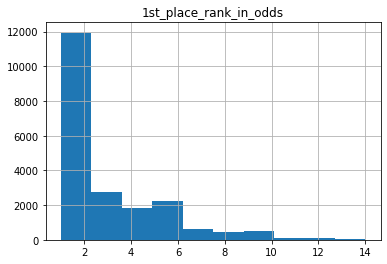

In [15]:
races_selected_augment_non_weather.hist('1st_place_rank_in_odds')

array([[<AxesSubplot:title={'center':'2nd_place_rank_in_odds'}>]],
      dtype=object)

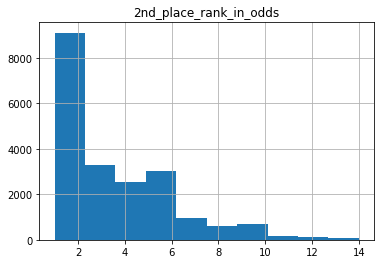

In [16]:
races_selected_augment_non_weather.hist('2nd_place_rank_in_odds')

array([[<AxesSubplot:title={'center':'3rd_place_rank_in_odds'}>]],
      dtype=object)

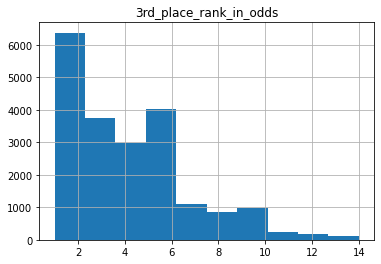

In [17]:
races_selected_augment_non_weather.hist('3rd_place_rank_in_odds')

Next, we add three columns that work in the opposite direction, called `1st_rank_in_odds_place`, `2nd_rank_in_odds_place`, and `3rd_rank_in_odds_place`. We explain the meaning of one of these columns, `1st_place_rank_in_odds`, whereas the others are symmetric.

A value $x$ in column `1st_rank_in_odds_place` means that, after sorting the odds in decreasing order (such that the horse _projected_ to win is at the front of this sorted list), the horse which was at the _front_ of the list actually placed at position $x$.

Note, in the `decimalPrice` column, higher numbers mean that the horse is more likely to win, according to the sportsbook.

In [18]:
rid_to_rank_in_odds_place = {}

for rid in tqdm(races_selected['rid']):
    horses = horses_selected[horses_selected['rid'] == rid][['position', 'decimalPrice']]
    
    top_three_place = horses.sort_values(by=['decimalPrice', 'position'], ascending=[False, True]).head(3)

    rid_to_rank_in_odds_place[rid] = {
        "1st_rank_in_odds_place": sum(horses['position'] < top_three_place.iloc[0]['position']) + 1,
        "2nd_rank_in_odds_place": sum(horses['position'] < top_three_place.iloc[1]['position']) + 1,
        "3rd_rank_in_odds_place": sum(horses['position'] < top_three_place.iloc[2]['position']) + 1,
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20574/20574 [00:55<00:00, 370.23it/s]


In [19]:
rename_cols = {
    'index': 'rid',
}

df_rank_in_odds_place = pd.DataFrame.from_dict(rid_to_rank_in_odds_place, orient='index') \
                                     .reset_index() \
                                     .rename(columns=rename_cols)

df_rank_in_odds_place.head()

,rid,1st_rank_in_odds_place,2nd_rank_in_odds_place,3rd_rank_in_odds_place
0,302858,1,6,3
1,291347,4,2,4
2,75447,5,2,1
3,358038,1,4,2
4,78982,1,3,3


In [20]:
races_selected_augment_non_weather = races_selected_augment_non_weather.merge(df_rank_in_odds_place, how='inner',
                                                                              on='rid')
races_selected_augment_non_weather.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,...,ncond,class,runners,margin,1st_place_rank_in_odds,2nd_place_rank_in_odds,3rd_place_rank_in_odds,1st_rank_in_odds_place,2nd_rank_in_odds_place,3rd_rank_in_odds_place
0,302858,Thurles (IRE),01:15,97/01/09,Liffey Maiden Hurdle (Div 1),NaN,NaN,5yo+,2m3f,Good,...,1,0,6,1.219263,1,5,3,1,6,3
1,291347,Punchestown (IRE),03:40,97/02/16,Ericsson G.S.M. Grand National Trial Handicap ...,NaN,NaN,5yo+,3m2f,Soft,...,5,0,9,1.218049,4,2,8,4,2,4
2,75447,Listowel (IRE),03:00,97/03/01,Ballybunion E.B.F. Beginners S'chase,NaN,NaN,4yo+,2m2f,Soft,...,5,0,8,1.277320,3,2,6,5,2,1
3,358038,Punchestown (IRE),02:40,97/04/24,Quinns Of Baltinglass Chase (La Touche) (Cross...,NaN,NaN,5yo+,4m1f,Good,...,1,0,10,1.286595,1,3,5,1,4,2
4,78982,Dundalk (IRE),05:15,97/05/02,Carlingford Handicap Chase,NaN,0-109,4yo+,3m,Firm,...,8,0,4,1.090018,1,4,2,1,3,3


Some EDA to make sure we have calculated the right thing. We expect the distribution to have a mode near lower values.

array([[<AxesSubplot:title={'center':'1st_rank_in_odds_place'}>]],
      dtype=object)

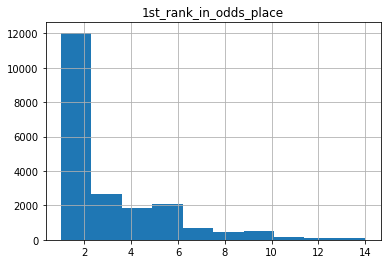

In [21]:
races_selected_augment_non_weather.hist('1st_rank_in_odds_place')

array([[<AxesSubplot:title={'center':'2nd_rank_in_odds_place'}>]],
      dtype=object)

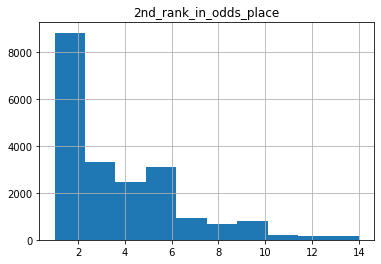

In [22]:
races_selected_augment_non_weather.hist('2nd_rank_in_odds_place')

array([[<AxesSubplot:title={'center':'3rd_rank_in_odds_place'}>]],
      dtype=object)

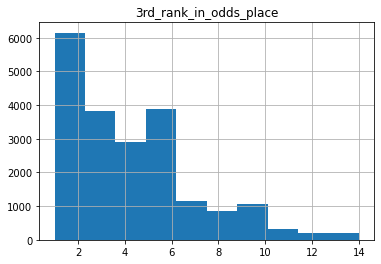

In [23]:
races_selected_augment_non_weather.hist('3rd_rank_in_odds_place')

We add three last columns revolving around the "favorite" of a race. These columns are `favoriteWon`, `favoritePlaced`, and `favoritedShowed`. These are binary columns which are 1 if the event described in the column has occured and 0 otherwise. These calculations use the most previous three columns added.

Prior to this, we add some additional information about the bets available as a function of how many runners there are.

In [24]:
rid_to_bets_available = {}

for _, row in tqdm(races_selected_augment_non_weather.iterrows()):
    
    rid_to_bets_available[row['rid']] = {
        "placeAvailable": int(row['runners'] >= 5),
        "showAvailable": int(row['runners'] >= 8),
    }

20574it [00:00, 22369.40it/s]


In [25]:
rename_cols = {
    'index': 'rid',
}

df_bets_available = pd.DataFrame.from_dict(rid_to_bets_available, orient='index') \
                                    .reset_index() \
                                    .rename(columns=rename_cols)

df_bets_available.head()

,rid,placeAvailable,showAvailable
0,302858,1,0
1,291347,1,1
2,75447,1,1
3,358038,1,1
4,78982,0,0


In [26]:
races_selected_augment_non_weather = races_selected_augment_non_weather.merge(df_bets_available,
                                                                              how='inner',
                                                                              on='rid')
races_selected_augment_non_weather[['runners',
                                    'placeAvailable',
                                    'showAvailable']].head(10)

,runners,placeAvailable,showAvailable
0,6,1,0
1,9,1,1
2,8,1,1
3,10,1,1
4,4,0,0
5,5,1,0
6,5,1,0
7,3,0,0
8,5,1,0
9,3,0,0


Now, we can continue.

In [27]:
rid_to_favorite_outcome = {}

for _, row in tqdm(races_selected_augment_non_weather.iterrows()):
    
    rid_to_favorite_outcome[row['rid']] = {
        "favoriteWon": int(row['1st_rank_in_odds_place'] == 1),
        "favoritePlaced": int(row['1st_rank_in_odds_place'] <= 2 and row['placeAvailable'] == 1),
        "favoriteShowed": int(row['1st_rank_in_odds_place'] <= 3 and row['showAvailable'] == 1),
    }

20574it [00:01, 19398.62it/s]


In [28]:
rename_cols = {
    'index': 'rid',
}

df_favorite_outcome = pd.DataFrame.from_dict(rid_to_favorite_outcome, orient='index') \
                                     .reset_index() \
                                     .rename(columns=rename_cols)

df_favorite_outcome.head()

,rid,favoriteWon,favoritePlaced,favoriteShowed
0,302858,1,1,0
1,291347,0,0,0
2,75447,0,0,0
3,358038,1,1,1
4,78982,1,0,0


In [29]:
races_selected_augment_non_weather = races_selected_augment_non_weather.merge(df_favorite_outcome,
                                                                              how='inner',
                                                                              on='rid')
races_selected_augment_non_weather[['runners',
                                    '1st_rank_in_odds_place',
                                    'favoriteWon',
                                    'favoritePlaced',
                                    'favoriteShowed']].head(10)

,runners,1st_rank_in_odds_place,favoriteWon,favoritePlaced,favoriteShowed
0,6,1,1,1,0
1,9,4,0,0,0
2,8,5,0,0,0
3,10,1,1,1,1
4,4,1,1,0,0
5,5,1,1,1,0
6,5,2,0,1,0
7,3,1,1,0,0
8,5,1,1,1,0
9,3,2,0,0,0


Some EDA to make sure we calculated the correct thing. We expect these to be fairly high since the sportsbook wants to present good odds that seem fair to bettors.

In [30]:
np.mean(races_selected_augment_non_weather['favoriteWon'])

0.3725089919315641

In [31]:
np.mean(
    races_selected_augment_non_weather[races_selected_augment_non_weather['placeAvailable'] == 1]['favoritePlaced']
)

0.5750442030815862

In [32]:
np.mean(
    races_selected_augment_non_weather[races_selected_augment_non_weather['showAvailable'] == 1]['favoriteShowed']
)

0.6709768275508897

---

## Save Dataframe

In [33]:
races_selected_augment_non_weather.to_csv(f"{BASE_DIR}/data/streamline/races_selected_augment_non_weather.csv",
                                          index=False)

---